# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [8]:


import pandas as pd


df = pd.read_csv("C:/Users/Mykola/Documents/GitHub/Data_science_hw_4/bikes_rent.csv")

print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

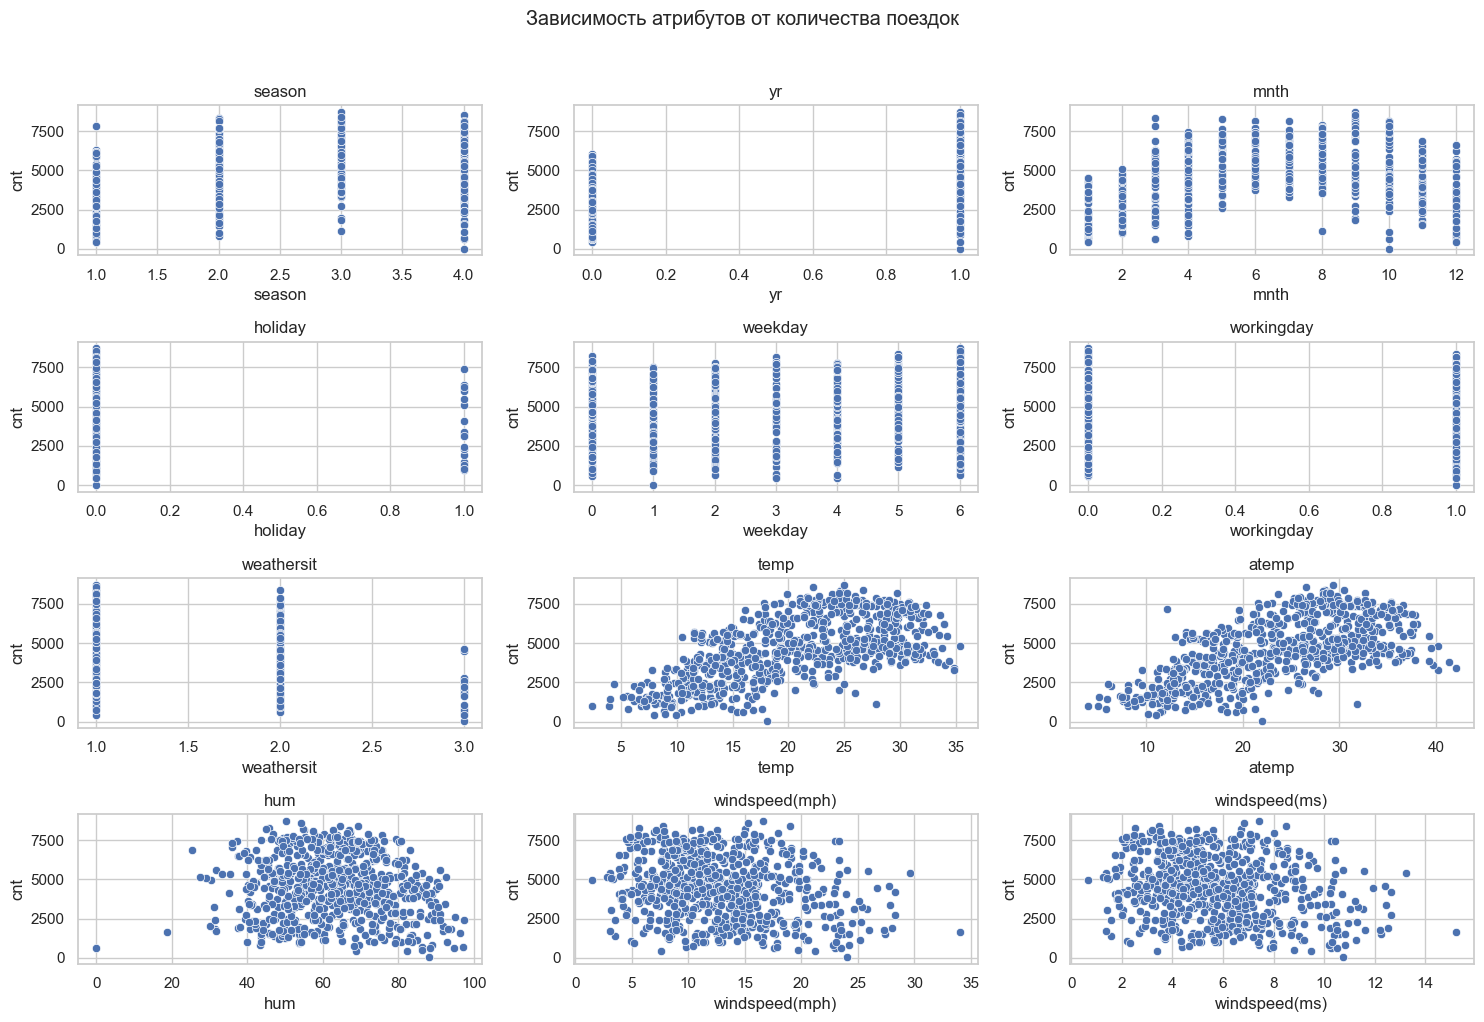

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
fig.suptitle('Зависимость атрибутов от количества поездок', y=1.02)

attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

for i, attribute in enumerate(attributes):
    row = i // 3
    col = i % 3
    sns.scatterplot(x=attribute, y='cnt', data=df, ax=axes[row, col])
    axes[row, col].set_title(attribute)

plt.tight_layout()
plt.show()


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [12]:
# Выборка всех признаков, кроме последнего (cnt)
features = df.iloc[:, :-1]

# Корреляции с последним признаком (cnt)
correlations_with_cnt = features.corrwith(df['cnt'])

# Вывод корреляций
print("Корреляции с целевым признаком (cnt):")
print(correlations_with_cnt)

# Корреляции между вещественными признаками
numeric_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
numeric_correlations = numeric_features.corr()

# Вывод корреляций между вещественными признаками
print("\nКорреляции между вещественными признаками:")
print(numeric_correlations)


Корреляции с целевым признаком (cnt):
season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

Корреляции между вещественными признаками:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt 

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [13]:
# Выборка признаков temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
selected_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]

# Попарные корреляции
correlations = selected_features.corr()

# Вывод корреляций
print("Попарные корреляции между признаками:")
print(correlations)


Попарные корреляции между признаками:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [14]:
# Вычисление средних признаков
mean_features = df.mean()

# Вывод средних признаков
print("Средние признаков:")
print(mean_features)


Средние признаков:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [16]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [17]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [18]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [20]:
from sklearn.linear_model import LinearRegression

# Создание объекта линейного регрессора
regressor = LinearRegression()

# Выборка признаков и целевой переменной
X = df.drop('cnt', axis=1)  # Все признаки, кроме целевой переменной
y = df['cnt']  # Целевая переменная

# Обучение регрессора на данных
regressor.fit(X, y)

# Вывод весов модели
feature_weights = list(zip(df.columns[:-1], regressor.coef_))
print("Веса модели:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")


Веса модели:
season: 514.2757015663954
yr: 2043.937499895518
mnth: -40.96324971851862
holiday: -519.3895390641574
weekday: 68.49560202791295
workingday: 121.29452237198859
weathersit: -606.4602424419659
temp: 48.99734615159841
atemp: 71.91309286915724
hum: -10.23025619299184
windspeed(mph): 2400641438973.261
windspeed(ms): -5370234899067.984


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [21]:
from sklearn.linear_model import Ridge, Lasso

# Создание объекта Ridge регрессора
ridge_regressor = Ridge()

# Обучение Ridge регрессора
ridge_regressor.fit(X, y)

# Вывод весов Ridge регрессора
ridge_weights = list(zip(df.columns[:-1], ridge_regressor.coef_))
print("Веса Ridge регрессора:")
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")

# Создание объекта Lasso регрессора
lasso_regressor = Lasso()

# Обучение Lasso регрессора
lasso_regressor.fit(X, y)

# Вывод весов Lasso регрессора
lasso_weights = list(zip(df.columns[:-1], lasso_regressor.coef_))
print("\nВеса Lasso регрессора:")
for feature, weight in lasso_weights:
    print(f"{feature}: {weight}")


Веса Ridge регрессора:
season: 507.8018818505662
yr: 2029.089054197048
mnth: -38.47089727912181
holiday: -493.27801548381984
weekday: 69.11396965165967
workingday: 121.52442502929445
weathersit: -605.2055553731512
temp: 49.31676759598137
atemp: 71.78598727335147
hum: -10.383394500484703
windspeed(mph): -31.93550169444566
windspeed(ms): -14.276040263482143

Веса Lasso регрессора:
season: 506.5512786498076
yr: 2036.231667697903
mnth: -38.078270289321665
holiday: -484.6519461865403
weekday: 68.93837479133961
workingday: 118.44759758668337
weathersit: -604.5667118927047
temp: 51.36326058561633
atemp: 69.91273749012194
hum: -10.352705204636578
windspeed(mph): -38.34106761310848
windspeed(ms): -0.0


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [22]:
from sklearn.linear_model import Ridge

# Создание объекта Ridge регрессора
ridge_regressor = Ridge()

# Обучение Ridge регрессора
ridge_regressor.fit(X, y)

# Вывод весов Ridge регрессора
ridge_weights = list(zip(df.columns[:-1], ridge_regressor.coef_))
print("Веса Ridge регрессора:")
for feature, weight in ridge_weights:
    print(f"{feature}: {weight}")


Веса Ridge регрессора:
season: 507.8018818505662
yr: 2029.089054197048
mnth: -38.47089727912181
holiday: -493.27801548381984
weekday: 69.11396965165967
workingday: 121.52442502929445
weathersit: -605.2055553731512
temp: 49.31676759598137
atemp: 71.78598727335147
hum: -10.383394500484703
windspeed(mph): -31.93550169444566
windspeed(ms): -14.276040263482143


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge

alphas = np.arange(1, 500, 50)

coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for index, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X, y)
    coefs_lasso[index] = lasso.coef_

for index, a in enumerate(alphas):
    ridge = Ridge(alpha=a)
    ridge.fit(X, y)
    coefs_ridge[index] = ridge.coef_

Проанализируйте динамику весов при увеличении параметра регуляризации:

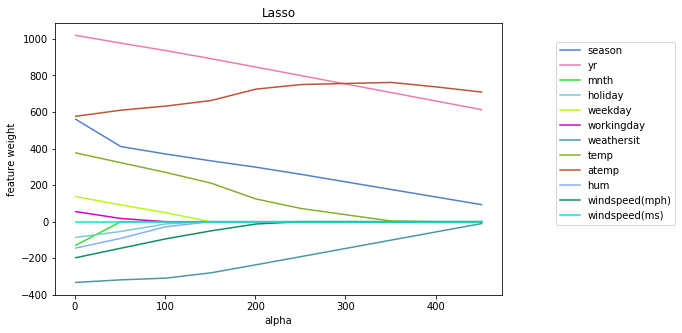

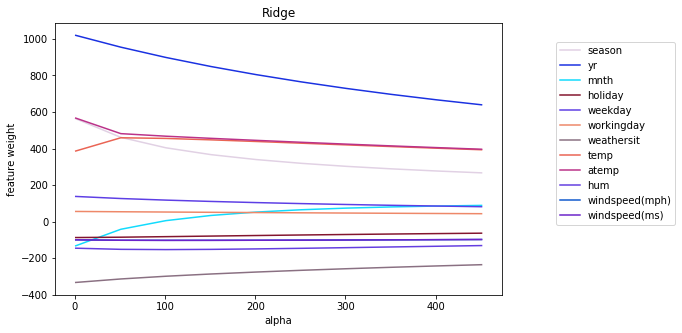

In [ ]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

In [26]:
# 1.Ответ: Lasso 
# 2. При увеличении значения alpha для Lasso все веса стремятся к нулю. Это происходит потому, 
# что L1-регуляризация включает штраф за абсолютные значения весов, и при увеличении alpha модель становится более склонной
# к минимизации суммы абсолютных значений весов,
# что может привести к обнулению некоторых из них.
# 3.Да, для Lasso можно утверждать, что она исключает один из признаков windspeed при любом значении alpha > 0. 
# Это видно на графиках, где один из весов windspeed стремится к нулю при увеличении alpha. В случае Ridge, 
# веса уменьшаются при увеличении alpha, но не стремятся к полному обнулению.
# 4. Lasso (L1-регуляризация) более подходит для отбора неинформативных признаков, 
# так как она может обнулять веса и, таким образом, исключать признаки из модели.
# Ridge (L2-регуляризация) уменьшает веса, но не обнуляет их полностью, 
# что делает ее менее способной к отбору признаков.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [27]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

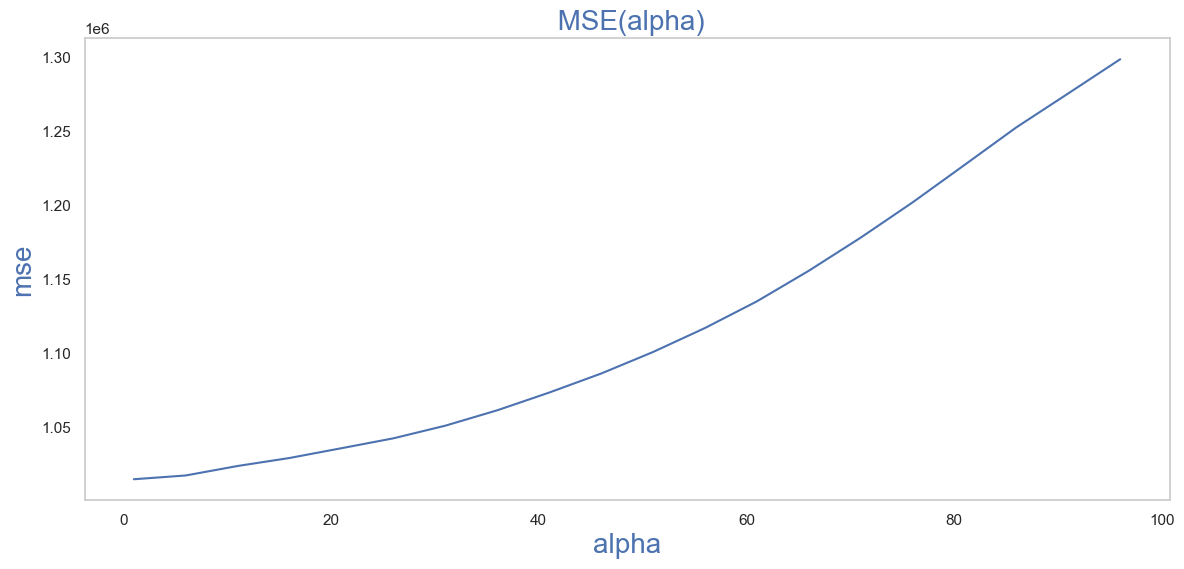

Alpha = 1


[('season', 506.5512786498076),
 ('yr', 2036.231667697903),
 ('mnth', -38.078270289321665),
 ('holiday', -484.6519461865403),
 ('weekday', 68.93837479133961),
 ('workingday', 118.44759758668337),
 ('weathersit', -604.5667118927047),
 ('temp', 51.36326058561633),
 ('atemp', 69.91273749012194),
 ('hum', -10.352705204636578),
 ('windspeed(mph)', -38.34106761310848),
 ('windspeed(ms)', -0.0)]

In [32]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor =  LassoCV(alphas=alphas).fit(X, y)

mse = [i.mean() for i in regressor.mse_path_]

plt.rcParams["figure.figsize"] = (14, 6)
plt.plot(regressor.alphas_, mse)
plt.title(' MSE(alpha)', fontsize=20, color='b')
plt.xlabel("alpha", fontsize=20, color='b')
plt.ylabel("mse", fontsize=20, color='b')
plt.grid()
plt.show()

print(f'Alpha = {regressor.alpha_}')
[i for i in list(zip(df.columns, regressor.coef_))]

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Alphas with minimum MSE:
Alpha = 96, MSE = 931196.5849871129
Alpha = 91, MSE = 922300.925283315
Alpha = 86, MSE = 912268.2644175201
Alpha = 81, MSE = 901467.3799149218
Alpha = 76, MSE = 891316.350151673
Alpha = 71, MSE = 881795.2099547178
Alpha = 66, MSE = 873085.8511630209
Alpha = 61, MSE = 865058.233639569
Alpha = 56, MSE = 857740.6796398746
Alpha = 51, MSE = 851309.7845801968
Alpha = 46, MSE = 845582.6538247234
Alpha = 41, MSE = 840496.3410727708
Alpha = 36, MSE = 835906.8177596115
Alpha = 31, MSE = 831111.2467712443
Alpha = 26, MSE = 827980.9346896898
Alpha = 21, MSE = 828902.9879016863
Alpha = 16, MSE = 831384.9771392574
Alpha = 11, MSE = 835406.7987605605
Alpha = 6, MSE = 840853.8130499249
Alpha = 1, MSE = 850357.2660457239


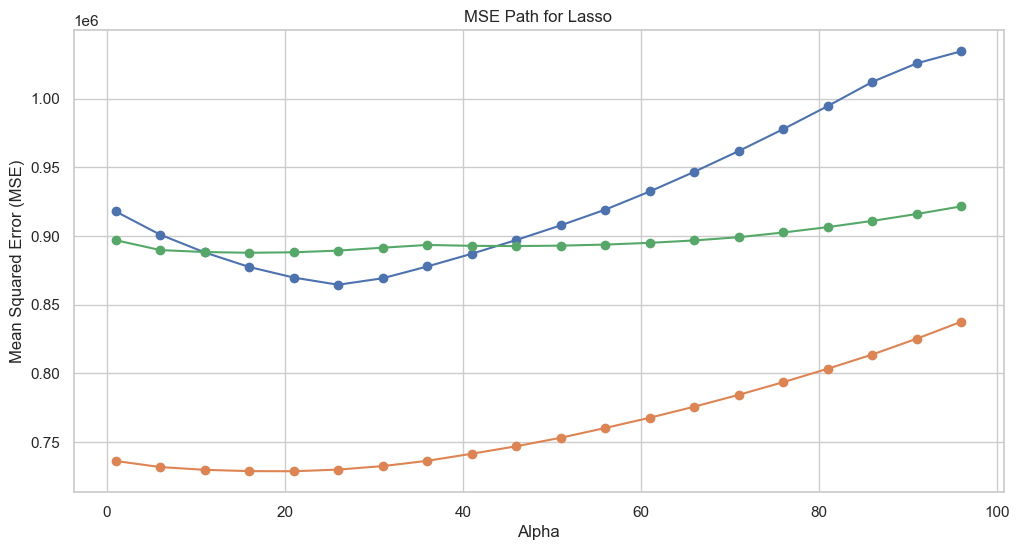

In [31]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_cv = LassoCV(alphas=np.arange(1, 100, 5), cv=3) 

lasso_cv.fit(X_train, y_train)

print("Alphas with minimum MSE:")
for i, alpha in enumerate(lasso_cv.alphas_):
    print(f"Alpha = {alpha}, MSE = {lasso_cv.mse_path_[i].mean()}")

plt.figure(figsize=(12, 6))
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Path for Lasso')
plt.show()



На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [33]:
# 
top_positive_indices = np.argsort(-lasso_cv.coef_)[:4]

# Имена признаков
top_positive_features = X.columns[top_positive_indices]

# Вывод имен признаков
print("4 признака с наибольшими положительными коэффициентами:")
print(top_positive_features)


#  можно сделать вывод, что более поздний год, более теплый сезон,
# более высокая температура по ощущениям и будний день могут влиять на увеличение числа велосипедных поездок.

4 признака с наибольшими положительными коэффициентами:
Index(['yr', 'season', 'atemp', 'weekday'], dtype='object')


#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [34]:

top_negative_indices = np.argsort(np.abs(lasso_cv.coef_))[-3:]


top_negative_features = X.columns[top_negative_indices]


print("3 признака с наибольшими по модулю отрицательными коэффициентами:")
print(top_negative_features)


3 признака с наибольшими по модулю отрицательными коэффициентами:
Index(['season', 'weathersit', 'yr'], dtype='object')


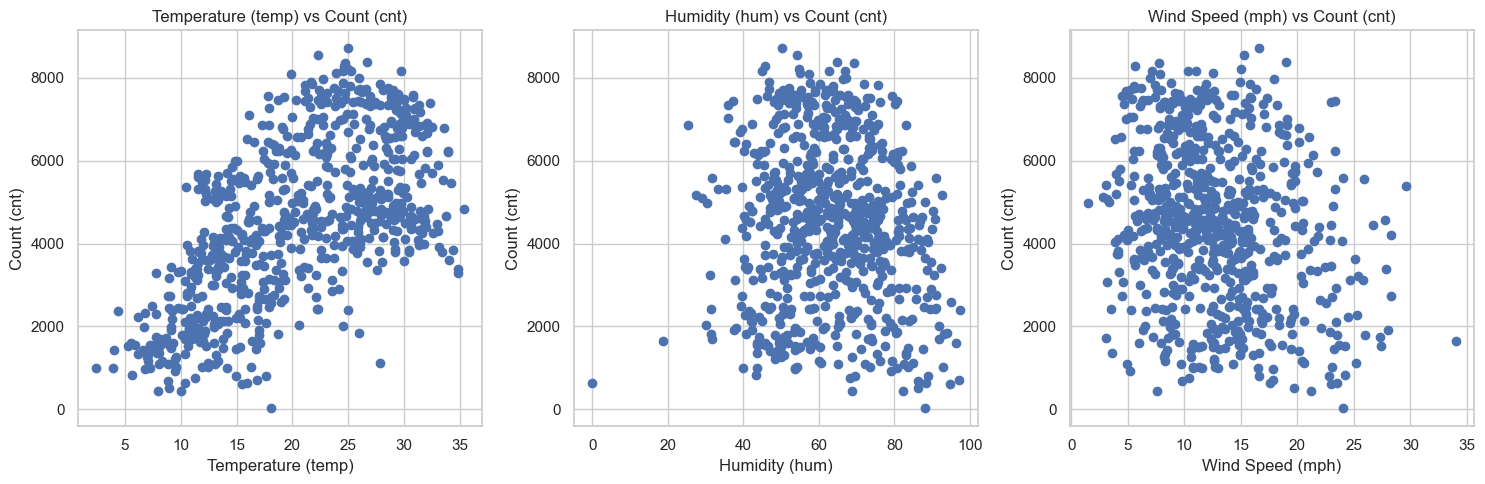

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df['temp'], df['cnt'])
plt.title('Temperature (temp) vs Count (cnt)')
plt.xlabel('Temperature (temp)')
plt.ylabel('Count (cnt)')

plt.subplot(1, 3, 2)
plt.scatter(df['hum'], df['cnt'])
plt.title('Humidity (hum) vs Count (cnt)')
plt.xlabel('Humidity (hum)')
plt.ylabel('Count (cnt)')

plt.subplot(1, 3, 3)
plt.scatter(df['windspeed(mph)'], df['cnt'])
plt.title('Wind Speed (mph) vs Count (cnt)')
plt.xlabel('Wind Speed (mph)')
plt.ylabel('Count (cnt)')

plt.tight_layout()
plt.show()


In [37]:
# Видна ли убывающая линейная зависимость?

# Для температуры в Цельсиях (temp) видна убывающая линейная зависимость: 
# с увеличением температуры увеличивается число велосипедных поездок.
# Для влажности (hum) убывающая линейная зависимость также заметна: 
# с уменьшением влажности увеличивается число велосипедных поездок.
# Для скорости ветра в милях в час (windspeed(mph)) наблюдается убывающая зависимость:
# с увеличением скорости ветра уменьшается число велосипедных поездок.


# Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

# Да, на основе анализа графиков и здравого смысла можно сделать вывод, что более высокая температура, 
# более низкая влажность и более высокая скорость ветра (в пределах разумных пределов) могут влиять на уменьшение 
# числа велосипедных поездок.






#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [38]:
near_zero_indices = np.where(np.abs(lasso_cv.coef_) < 1e-3)[0]

near_zero_features = X.columns[near_zero_indices]

print("Признаки с коэффициентами, близкими к нулю:")
print(near_zero_features)


Признаки с коэффициентами, близкими к нулю:
Index(['holiday', 'windspeed(ms)'], dtype='object')


In [ ]:
#  Из результатов выше видно, что признаки с коэффициентами, близкими к нулю (< 1e-3), включают 'holiday' и 'windspeed(ms)'.

# Вероятные причины:

# holiday: Этот признак может быть слабо связан с изменением спроса на велосипеды. Например, в праздничные дни люди могут выбирать другие формы транспорта или участвовать в мероприятиях, не связанных с велосипедами.

# windspeed(ms): Этот признак вторичен по отношению к windspeed(mph), так как это просто перевод из одной единицы в другую. Модель, вероятно, решила, что оба признака несут схожую информацию, и предпочла оставить только один из них.



# Вывод о том, что эти признаки "никак не влияют" может быть не совсем точным. Они, возможно, просто имеют слабое влияние или могут быть линейно зависимыми с другими признаками, поэтому их вклад может быть затруднительным для моделирования.

# Важно отметить, что даже если коэффициенты признаков близки к нулю, это не обязательно означает, что признаки абсолютно неважны. Влияние признаков следует рассматривать в контексте всей модели и с учетом возможных взаимосвязей между признаками.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.